# Speech2Text

## Introduction  

In this notebook,  a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline is built!  

## The Data

We begin by investigating the dataset that will be used to train and evaluate our pipeline.

[LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains **1000 hours of speech derived from audiobooks**. 

We work with a small subset in this project, since larger-scale data would take a long while to train.


In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2023 total training examples.


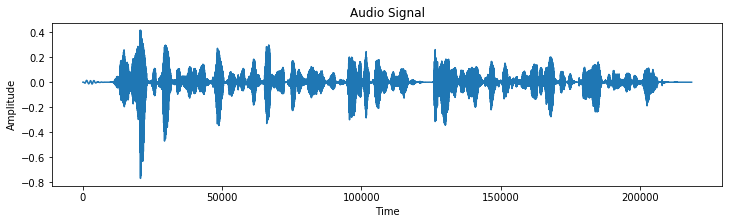

**Shape of Audio Signal** : (218626,)

**Transcript** : shortly after passing one of these chapels we came suddenly upon a village which started up out of the mist and i was alarmed lest i should be made an object of curiosity or dislike

LibriSpeech/dev-clean/2412/153954/2412-153954-0000.wav


In [11]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio, display
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
display(Audio(vis_audio_path))

print(vis_audio_path)

In [27]:
import wave
f = wave.open(vis_audio_path,'r')
print(f.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=158640, comptype='NONE', compname='not compressed')



##  1. Acoustic Features for Speech Recognition


### Spectrograms

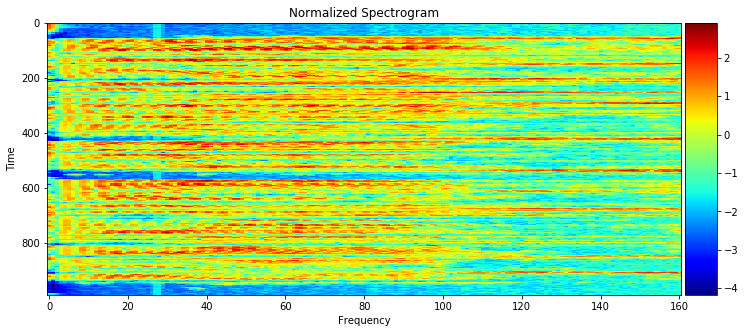

**Shape of Spectrogram** : (990, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs) 

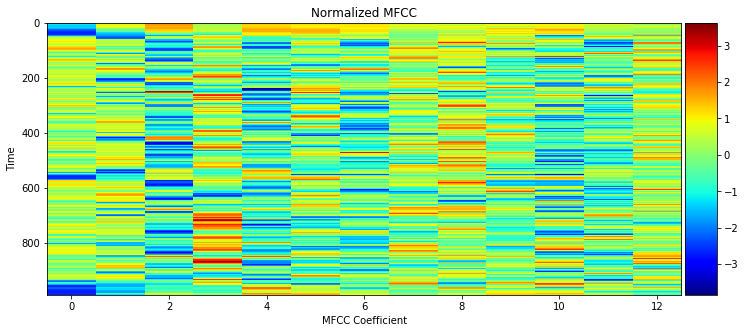

**Shape of MFCC** : (990, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

## 2. Deep Neural Networks for Acoustic Modeling

In [5]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))
#%reload_ext autoreload
%load_ext autoreload
%autoreload 2

from sample_models import *
from train_utils import train_model

Using TensorFlow backend.


In [6]:
#Hide warnings from tensorflow
tf.logging.set_verbosity(tf.logging.ERROR)

### Model 0: RNN

In [7]:
model_0 = simple_rnn_model(input_dim=13)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          3741      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=False) 

### Model 1: RNN + TimeDistributed Dense

In [8]:
model_1 = rnn_model(input_dim=13, 
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         128400    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 135,029
Trainable params: 134,629
Non-trainable params: 400
_________________________________________________________________
None


- The first layer of the neural network uses an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.

- The hidden layer in `simple_rnn_model` treats the RNN output as the input to the final layer of the model, and we use `TimeDistributed` in this hidden step to apply a `Dense` connection layer to each of the time steps in the RNN output. 

- The output layer ensures that each `Dense` layer has `output_dim` units, but is essentially plugged straight into the RNN's probability predictions.

In [ ]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=False) 



### Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a 1D convolution layer

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

In [9]:
model_2 = cnn_rnn_model(input_dim=13,
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [ ]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=False)

### Model 3: Deeper RNN + TimeDistributed Dense

In [10]:
model_3 = deep_rnn_model(input_dim=13,
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         128400    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 200)         800       
_________________________________________________________________
rnn_2 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [ ]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=False)

### Model 4: Bidirectional RNN + TimeDistributed Dense

[Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.

In [12]:
model_4 = bidirectional_rnn_model(input_dim=13,
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         256800    
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 400)         1600      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 270,029
Trainable params: 269,229
Non-trainable params: 800
_________________________________________________________________
None


In [ ]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=False)

### Model 5: Deep Bidirectional RNN + TimeDistributed Dense

In [13]:
model_5 = deep_bidirectional_rnn_model(input_dim=13,
                         units=200,
                         recur_layers=3,
                         RNN_type=GRU)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         256800    
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 400)         1600      
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 400)         1600      
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 400)         1600      
__________

In [ ]:
train_model(input_to_softmax=model_5, 
            pickle_path='model_5.pickle', 
            save_model_path='model_5.h5', 
            spectrogram=False)

### Compare the Models

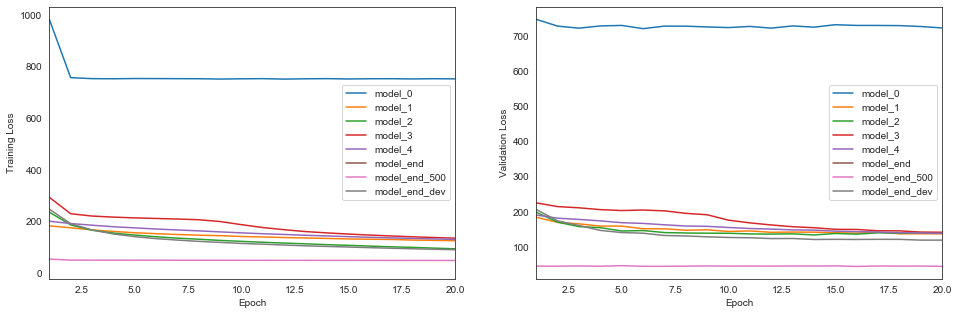

In [14]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

### Final Model

In [15]:
model_end = final_model_upd(input_dim=13, 
                        filters=200, 
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid', 
                        recur_layers=3, 
                        RNN_type=GRU, 
                        dropout=0.2, 
                        units=200, 
                        output_dim=29) # 200 Filters of 11x11, 
                                       # with a stride of 2, with "valid" / no padding
                                       # Using 3 RNN Bidirecional Chains with GRU Units
                                       # Over 200 Units, with 20% Dropout, in Sequences of 29

# CNN -> Bidirectional RNN Stacks
# model_end = final_model(input_dim=13,
#                        rnn_units=500,
#                        filters=50,
#                        kernel_size=3,
#                        conv_stride=1,
#                        conv_border_mode='same',
#                        pool_ksize=2,
#                        pool_stride=2,
#                        pool_border_mode='valid',
#                        dropout_prob=0.2,
#                        cell_type='gru')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 400)         1600      
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 400)         1600      
__________

In [ ]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=False) 

## Compare train loss and validation loss

Validation Loss: 45.18
Train Loss: 49.25


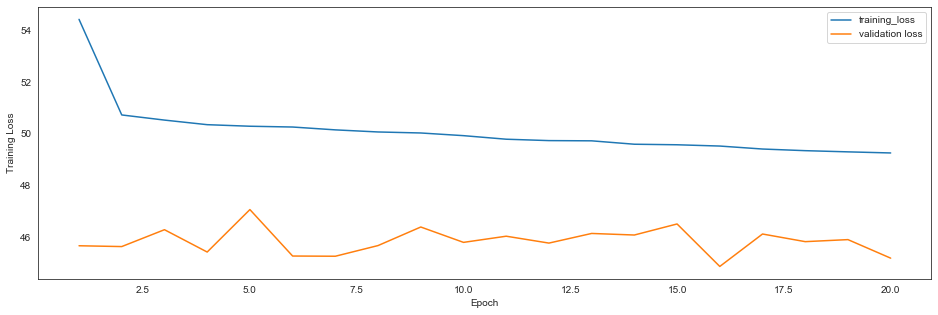

In [16]:
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

model_path = 'results/model_end_500.pickle'

# extract the loss history for each model
valid_loss = pickle.load( open(model_path, "rb" ) )['val_loss']
train_loss = pickle.load( open(model_path, "rb" ) )['loss']
# save the number of epochs used to train each model
num_epochs = len(valid_loss)

plt.figure(figsize=(16,5))

plt.plot(np.linspace(1, num_epochs, num_epochs), 
        train_loss, label='training_loss')
plt.plot(np.linspace(1, num_epochs, num_epochs), 
        valid_loss, label='validation loss')

# clean up the plot
plt.legend()  
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

print("Validation Loss: {:.2f}\nTrain Loss: {:.2f}".format(valid_loss[-1], train_loss[-1]))

The model consists of 9 layers, depending on how many recursive RNN chains are used (3 here).

1) **Input**: An input vector of *BatchID, 161* (Spectograms)

`Input(shape=(None, input_dim))`

2) **Convolution**: N filters, using specified kernel size, stride, and padding, mapping over the image and activating via ReLU

`Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv1d')(input)`
                     
3) **Batch Normalization**: Noise reduction layer, normalizing outliers

`BatchNormalization(prev)`

4-6) **RNN Layers** - A chain of bidirectional RNNs to improve temporal comprehension, returning in sequences, with dropout. 

`for i in range(recur_layers): 
rnn = Bidirectional(RNN_type(units, 
activation='relu',
    return_sequences=True, 
    implementation=2, 
    recurrent_dropout=dropout, 
    dropout=dropout, 
    name='bidir_rnn_{}'.format(i + 1)))(prev)` 
    
7) **Batch Normalization**: Another Noise reduction layer, normalizing outliers

`BatchNormalization(prev)` 

8) **Dense Activation**: Relate every sequence in every RNN densely with the next layer.

`TimeDistributed(Dense(prev))` 

9) **Final Activation**: Pass each densely connected unit to Softmax activation for probability prediction.

`Activation('softmax')(prev)`

Then we specify inputs and outputs, pad the uneven sequences, use our pickled hyperparameters, and find predictions!

## 3. Obtain Predictions

In [38]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path, desc_file):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.__init__(spectrogram=False)
    data_gen.load_train_data(desc_file=desc_file)
    data_gen.load_validation_data(desc_file=desc_file)

    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    print("output length: {}".format(output_length))
    test_text = (K.eval(K.ctc_decode(prediction, output_length,greedy=False,top_paths=2)[0][1])+1).flatten().tolist()
    #print ('test:'  + ''.join(int_sequence_to_text(test_text)))
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length,greedy=False,top_paths=2)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*65)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*65)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*65)
    return "".join(int_sequence_to_text(pred_ints))

In [39]:
valid_predicted_text = get_predictions(index=0, 
                    partition='train',
                    input_to_softmax=final_model_upd(input_dim=13, 
                            filters=100,
                            kernel_size=11, 
                            conv_stride=2,
                            conv_border_mode='same',
                            units=100), 
                    model_path='./results/model_end_500.h5',desc_file="train_corpus.json")


test_predicted_text = get_predictions(index=2, 
                partition='validation',
                input_to_softmax=final_model_upd(input_dim=13, 
                        filters=100,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='same',
                        units=100),
                model_path='./results/model_end_500.h5',desc_file="valid_corpus.json")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 100)         14400     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 100)         400       
_________________________________________________________________
bidirectional_41 (Bidirectio (None, None, 200)         120600    
_________________________________________________________________
batch_normalization_45 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_42 (Bidirectio (None, None, 200)         180600    
_________________________________________________________________
batch_normalization_46 (Batc (None, None, 200)         800       
__________

## Spelling checks

In [40]:
def suggest(word,desc_file):
    return bigram_suggesstions(word,generate_corpus(desc_file=desc_file))

In [41]:
from textblob import TextBlob

blob = TextBlob(test_predicted_text)
print("-"*80)
print("Spelling corecctection: \n\n{}".format(blob.correct()))
print("-"*80)

--------------------------------------------------------------------------------
Spelling corecctection: 

must ave al robin thought of his father but what he count
--------------------------------------------------------------------------------


## N-Gram Implementation

In [42]:
from collections import defaultdict
from language_model import *
import re

correct_text = []
# Append the first word assuming that is correct 
#correct_text.append(test_predictedText.split()[0])
correct_text.append(blob.correct().split()[0])

# Assuming the prediction size same as the ground truth one
for word_indx in range(len(test_predictedText.split())-1):
    # Checking if next_word is in suggested words
    #next_word = test_predictedText.split()[word_indx+1]
    next_word = blob.correct().split()[word_indx+1]
    dict_ = suggest(correct_text[-1],"valid_corpus.json")
    if next_word not in dict_:
        # Return to the function once the word is predicted
        def innerLoop():
            # Spelling might not be correct so it start with the original length and reduces one by one
            for i in range(len(next_word)):
                # Find matching key using regular expressions 
                found = re.compile(next_word[0:len(next_word)-i])
                for key in dict_.keys():
                    if found.match(key):
                        print("N-Gram prediction of word {} is {}".format(next_word,key))
                        correct_text.append(key)
                        return 
                    elif len(dict_.keys()) == 1:
                        for key in dict_.keys():
                            print("N-Gram prediction of word {} is {}".format(next_word,key))
                            correct_text.append(key)
                            return
        innerLoop()
      
    else:
        print("Word prediction is correct for  {}".format(next_word))
        correct_text.append(next_word)
               
print("-"*65)
print("Language Model Prediction: \n\n"+" ".join(correct_text))
print("-"*65)

N-Gram prediction of word ave is acknowledge
N-Gram prediction of word al is that
Word prediction is correct for  robin
Word prediction is correct for  thought
Word prediction is correct for  of
Word prediction is correct for  his
Word prediction is correct for  father
Word prediction is correct for  but
Word prediction is correct for  what
Word prediction is correct for  he
N-Gram prediction of word count is counterfeited
-----------------------------------------------------------------
Language Model Prediction: 

must acknowledge that robin thought of his father but what he counterfeited
-----------------------------------------------------------------


## Obtain predictions from speech

In [44]:
from audio_utils import record_to_file
def get_predictions_live(input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        file_path (str): The path to example you would like to visualize'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    dir_path = '/Users/user/Desktop/Audios'
    audio_path = record_to_file(dir_path)

    
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.__init__(spectrogram=False)
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the audio features
    data_point = data_gen.normalize(data_gen.featurize(audio_path))


        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the predicted transcriptions
    print('-'*65)
    Audio(audio_path)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*65)
    return "".join(int_sequence_to_text(pred_ints))

In [46]:
predicted_text = get_predictions_live(input_to_softmax=final_model_upd(input_dim=13, 
                            filters=100,
                            kernel_size=11, 
                            conv_stride=2,
                            conv_border_mode='same',
                            units=100), 
                    model_path='./results/model_end_500.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 100)         14400     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 100)         400       
_________________________________________________________________
bidirectional_50 (Bidirectio (None, None, 200)         120600    
_________________________________________________________________
batch_normalization_54 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_51 (Bidirectio (None, None, 200)         180600    
_________________________________________________________________
batch_normalization_55 (Batc (None, None, 200)         800       
__________

-----------------------------------------------------------------
Predicted transcription:

ia lok to wrid my by cicle
-----------------------------------------------------------------


## Refences
As a skeleton for this file a task from [Udacity](https://github.com/udacity/AIND-VUI-Capstone) was used.